# Integrating Multi-Chain MCMC and Arviz Functionality into the HDDM

As is well known, the HDDM itself does not support fitting multiple chains in MCMC, so fitting an HDDM model with multiple chains requires users to perform complex customization. In addition, the Bayesian plotting and testing capabilities included in HDDM are relatively rudimentary, and leveraging arviz (based on xarray's InferenceData) can help users perform more flexible post-analysis.

Previous work in our laboratory, [HDDMdocker](https://github.com/hcp4715/dockerHDDM_Guide), has implemented multiple-chain MCMC fitting and conversion of hddm models to arviz InferenceData. However, these methods have not been well integrated into the modules on which hddm itself depends. This work ported these features to the core dependency library of hddm, kabuki, which fundamentally solves the problems that existed before and makes it more convenient for users to use.

We hope that this notebook can provides a good example of how to use our advanced update to run multiple chains in parallel and generate an ArViz InferenceData from the hddm class.

First, please uninstall the current version of Kabuki and install the development version from Gitee at https://gitee.com/epool/kabuki. ↗

Our work in this version is based on Kabuki, which is compatible with hddm >= 0.8.0. To install Kabuki from Gitee, use the following command:

In [1]:
import hddm
import kabuki
import arviz as az

print("The current version of kabuki is: ", kabuki.__version__)
print("The current version of HDDM is: ", hddm.__version__)
print("The current version of arviz is: ", az.__version__)

HDDM: pytorch module seems missing. No LAN functionality can be loaded.
It seems that you do not have pytorch installed. You cannot use the network_inspector module.
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor, HDDMnnStimCoding, HDDMnnRL and HDDMnnRLRegressorclasses will not work
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor, HDDMnnStimCoding, HDDMnnRL and HDDMnnRLRegressorclasses will not work
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor and HDDMnnStimCodingclasses will not work
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRL, HDDMnnRegressor, HDDMnnStimCoding, HDDMnnRL and HDDMnnRLRegressorclasses will not work
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor, HDDMnnStimCoding, HDDMnnRL and HDDMnnRLRegressorclasses will not work
The current version of kabuki is:  0.6.5RC1
The current version of HDDM is:  0.9.8
The current version of arviz is:  0

Loading the data from the hddm package

In [2]:
data = hddm.load_csv(hddm.__path__[0] + "/examples/cavanagh_theta_nn.csv")
data = data[data['subj_idx'].isin([0,1,2])]
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,0.0,-0.213236,1,HC


Sampling a basic model to ensure that the python enviroment is working properly. 

In [13]:
model = hddm.HDDM(data, include = ['v', 'a', 't', 'z'])
model.sample(100)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 100 of 100 complete in 0.6 sechddm sampling elpased time:  0.637 s


### Basic Bayesian hierarchical model

Now, let we **run the model with 2 chains in parallel**, and **return the ArViz InferenceData**.

In [4]:
model0 = hddm.HDDM(data, include = ['v', 'a', 't', 'z'])
# note: when chains more than one, sampling process will be run parallelly, and the _temp*.db will be saved in the current directory
InfData0 = model0.sample(500, chains = 2, InfData = True)
InfData0

No model attribute --> setting up standard HDDM
Set model to ddm
HDDM: pytorch module seems missing. No LAN functionality can be loaded.
It seems that you do not have pytorch installed. You cannot use the network_inspector module.
HDDM: pytorch module seems missing. No LAN functionality can be loaded.
It seems that you do not have pytorch installed. You cannot use the network_inspector module.
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor, HDDMnnStimCoding, HDDMnnRL and HDDMnnRLRegressorclasses will not work
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor, HDDMnnStimCoding, HDDMnnRL and HDDMnnRLRegressorclasses will not work
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor and HDDMnnStimCodingclasses will not work
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRL, HDDMnnRegressor, HDDMnnStimCoding, HDDMnnRL and HDDMnnRLRegressorclasses will not work
It seems that you do not have pyto

Inference data with groups:
	> posterior
	> observed_data

Then we used the arviz to diagnose the model. 

We can obtain the Rhat, ess, and other diagnostic for each parameter.

In [4]:
az.summary(InfData0).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.056,0.493,1.225,3.116,0.091,0.069,46.0,29.0,1.04
a_std,0.978,1.954,0.176,2.102,0.246,0.175,33.0,213.0,1.05
a_subj.0,2.203,0.084,2.055,2.315,0.005,0.003,381.0,357.0,1.00
a_subj.1,2.158,0.320,1.976,2.240,0.051,0.036,152.0,70.0,1.02
a_subj.2,2.108,1.389,1.427,5.478,0.694,0.531,8.0,11.0,1.17


We could also plot the traceplot and posterior distribution for each parameter to check the convergence of the model.

Note: different chains are plotted in different colors.

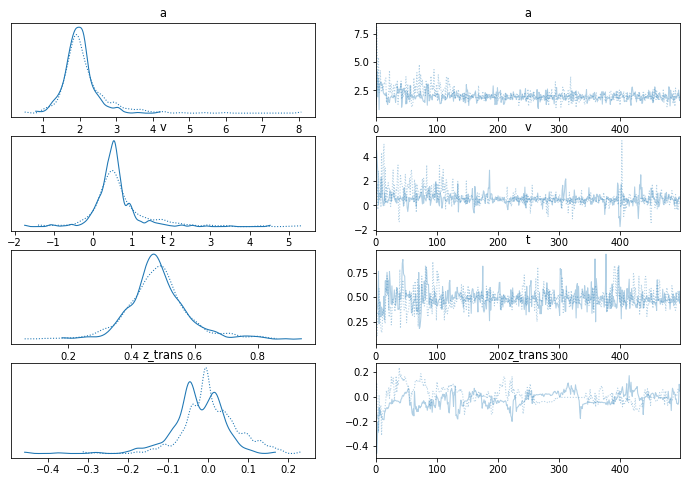

In [8]:
fig = az.plot_trace(InfData0, var_names = ['a', 'v', 't', 'z_trans'])

### HDDM with regressors

Next, we will try a more complex model, such as hddm with regressors. 
- In this example, we show how to save a model to an arbitrary directory using the `save_name` argument. 
- To enable model comparison, we have added the `loglike = True` argument to calculate the pointwise log likelihood of the model, which can be further used for calculating WAIC and LOOIC. 
- Additionally, we have added the `ppc = True` argument, which allows us to generate posterior predictive checks for the model."

In [9]:
model_reg = hddm.HDDMRegressor(data, 'v~C(conf)',include = ['v', 'a', 't', 'z'])
# note: setting save_name argument will delete the _temp*.db file
save_name = "test/hddmregressor_example"
InfData1 = model_reg.sample(500, chains = 2, InfData = True, loglike = True, ppc = True, save_name = save_name)

Adding these covariates:
['v_Intercept', 'v_C(conf)[T.LC]']
Start to calculate pointwise log likelihood...
Start generating posterior prediction...
Start converting to InferenceData...
hddm sampling elpased time:  538.324 s


In [10]:
InfData1

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

We can see the InfData consist of four parts, including the posterior, posterior_predictive, log_likelhood, and observed_data.

When you set the 'save_name' argument to a `str` of the desired file path, hddm will save the model to two files in that location: the model itself (e.g. `hddmregressor_example.hddm`) and the trace of the model (`hddmregressor_example.db`). 

Additionally, if you use the argument `InfData = True`, it convert the hddm model to ArViz InferenceData, the InferenceData will also be saved to the same path (`hddmregressor_example.nc`).

As a result, we can easily load the model and InferenceData using the following code:

In [8]:
save_name = "test/hddmregressor_example"

In [9]:
model_reg = hddm.load(save_name + ".hddm")
InfData2 = az.from_netcdf(save_name + ".nc")

Then we can use the InferenceData to calculate WAIC and LOOIC.

In [7]:
hddm_reg_LOO = az.loo(InfData1)
hddm_reg_LOO

Computed from 1000 posterior samples and 889 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2215.95   219.32
p_loo     1019.64        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      687   77.3%
 (0.5, 0.7]   (ok)         77    8.7%
   (0.7, 1]   (bad)        42    4.7%
   (1, Inf)   (very bad)   83    9.3%

### model comparison with LOO

Relative to the model_reg, which hypothesizes that task conditions (i.e., variable conf) affect the drift rate, our second model, model_reg2, assumes that task conditions affect the boundary.

To compare the two models and hypotheses, we built the second model, model_reg2, with the linear formula 'a~C(conf)'.

We can then use the `az.compare` function to compare the two models.

In [11]:
model_reg2 = hddm.HDDMRegressor(data, 'a~C(conf)',include = ['v', 'a', 't', 'z'])
InfData2 = model_reg2.sample(500, chains = 2, InfData = True, loglike = True, ppc = True)

# another way is to use conver2InfData methods with loglike=True
# InfData2 = model_reg2.conver2InfData(loglike=True)
# but ensure that the '_temp*.db' file for each chain is in the current directory 
# because we don't save this model

No model attribute --> setting up standard HDDM
Set model to ddm
HDDM: pytorch module seems missing. No LAN functionality can be loaded.
It seems that you do not have pytorch installed. You cannot use the network_inspector module.
HDDM: pytorch module seems missing. No LAN functionality can be loaded.
It seems that you do not have pytorch installed. You cannot use the network_inspector module.
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor, HDDMnnStimCoding, HDDMnnRL and HDDMnnRLRegressorclasses will not work
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor, HDDMnnStimCoding, HDDMnnRL and HDDMnnRLRegressorclasses will not work
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor and HDDMnnStimCodingclasses will not work
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRL, HDDMnnRegressor, HDDMnnStimCoding, HDDMnnRL and HDDMnnRLRegressorclasses will not work
It seems that you do not have pyto

In [10]:
compare_dict = {"H: v ~ conf": InfData1, "H: a ~ conf": InfData2}
az.compare(compare_dict)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
H: a ~ conf,0,-1996.218943,783.589587,0.000000,0.410301,198.704443,0.000000,True,log
H: v ~ conf,1,-2215.950548,1019.644793,219.731605,0.589699,219.320048,99.452752,True,log


### posterior predictive checks

We can see that the model with varing of decision boundary is better than the model with varing of drift rate. 

Futhermore, we can plot the posterior predictive checks to check the best model.

The below code show how to plot the ppc for each subject like the hddm's `plot_posterior_predictive` (e.g. `model_reg.plot_posterior_predictive(figsize=(14, 10))`)

array([<AxesSubplot: xlabel='rt / rt\n0'>,
       <AxesSubplot: xlabel='rt / rt\n1'>,
       <AxesSubplot: xlabel='rt / rt\n2'>], dtype=object)

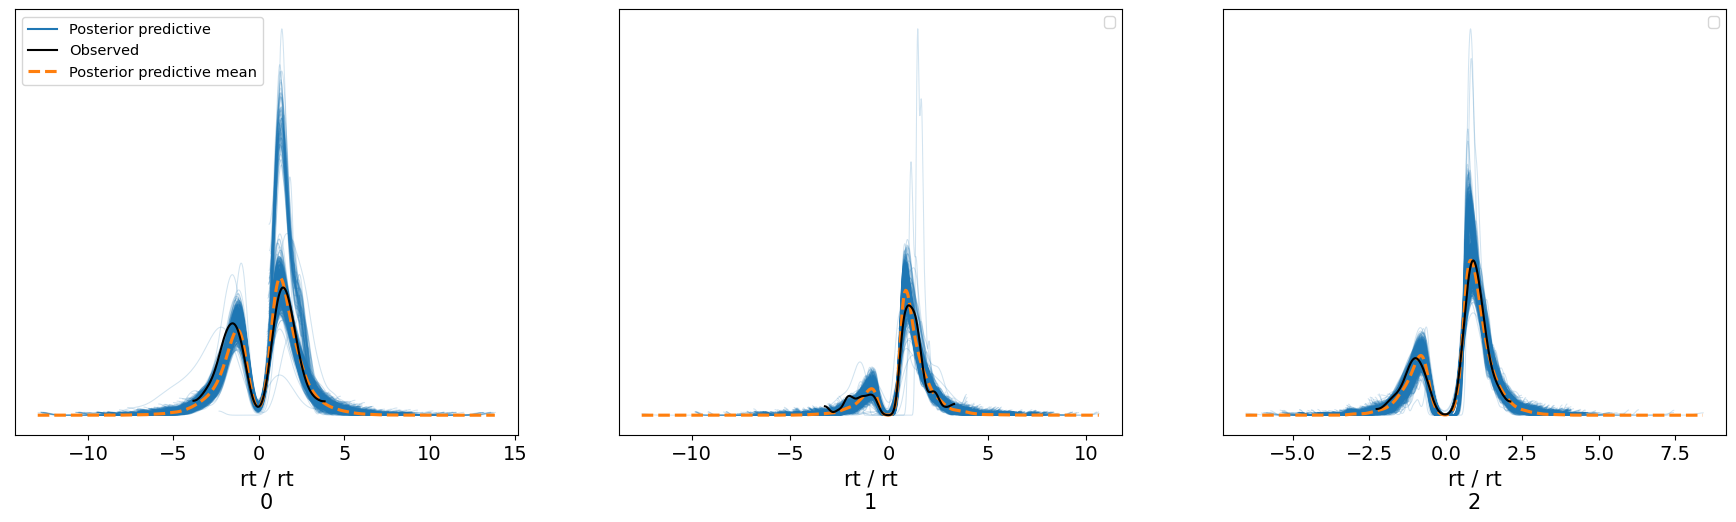

In [12]:
InfData2 = InfData2.assign_coords(
  obs_id=InfData2.observed_data.coords['subj_idx'].values, 
  groups="observed_vars")

az.plot_ppc(InfData2, var_names= 'rt', coords={'obs_id': [0, 1, 2]}, flatten=[])

In conclusion, our contribution has three key benefits:
1. You now have the freedom to save the model to any desired path, even if it is not available in the original hddm.
2. Rather than generating separate db files for each chain (which could not be moved to other paths in the previous version), we now save all chains' db files in a single location of your choosing.
3. We provide a simple way to convert the hddm model to ArViz InferenceData, which allows you to calculate pointwise loglikelihood for model comparison (e.g. WAIC and LOOIC), and generate predictions for model checking (e.g. posterior predictive checks)."

Lastly, I hope you enjoy using this version as it will be beneficial to your modeling work.

If you have any questions, please contact me at [panwanke@163.com](panwanke@163.com) or commit an issue at [epool/kabuki](https://gitee.com/epool/kabuki/issues) ↗